------current epoch:0------
16791.0703125
2914.630126953125
8426.7802734375
9446.1689453125
9247.681640625
4648.1279296875
23687.654296875
11251.0908203125
******the cost of epoch 0 is 12862.216997750198******
------current epoch:1------
14779.974609375
18231.513671875
10898.025390625
13569.001953125
12470.9853515625
2858.962890625
5768.36328125
6766.9453125
******the cost of epoch 1 is 12669.977430280855******
------current epoch:2------
11609.0986328125
9164.33984375
13155.603515625
18078.591796875
20860.61328125
2285.84326171875
14451.3740234375
15758.9091796875
******the cost of epoch 2 is 12488.48808346519******
------current epoch:3------
13100.6474609375
8129.58740234375
9390.4501953125
7979.6953125
16371.7255859375
9143.923828125
31006.130859375
20003.916015625
******the cost of epoch 3 is 12246.24311152591******
------current epoch:4------
8032.498046875
16237.27734375
13522.39453125
7161.50341796875
8259.080078125
19594.501953125
4458.84326171875
12661.9130859375
******the co

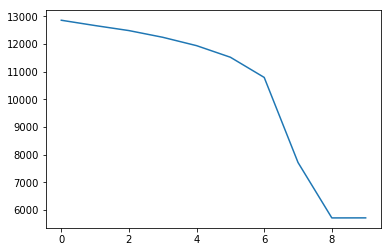

14829.163504838943


In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue May 29 10:37:42 2018

@author: wangz
"""

#import numpy as np
import random
import lda
import torch
import torch.nn as nn
#import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import time
t = time.time()

data = lda.datasets.load_reuters()
data.dtype = 'int'
vocab = lda.datasets.load_reuters_vocab()
docum = lda.datasets.load_reuters_titles()

V = len(vocab)
D = len(docum)
word_to_id = {}

for i in range(V):
    word_to_id[vocab[i]] = i


#embeds = nn.Embedding(V_size, 20)
##words = embeds(torch.tensor([word_to_id], dtype=torch.long)) 
#lookup_tensor = torch.tensor([word_to_id.values()], dtype=torch.long)
#hello_embed = embeds(lookup_tensor)
#print(hello_embed)

class Toy(nn.Module):
    def __init__(self, vocab_size, v_dim, topic_size, k_dim):
        super(Toy, self).__init__()
        self.vocab_size = vocab_size
        self.topic_size = topic_size
        self.v_dim = v_dim
        self.k_dim = k_dim
        self.voc_embed = torch.zeros(v_dim, vocab_size,  requires_grad=False)
        self.top_embed = torch.zeros(k_dim, topic_size,  requires_grad=False)
        self.alpha = torch.zeros(topic_size, vocab_size,  requires_grad=False)
        self.mu = torch.zeros(v_dim, vocab_size,  requires_grad=False)

        self.embedV = nn.Embedding(vocab_size, v_dim)
        self.embedT = nn.Embedding(topic_size, k_dim)
        self.B = nn.Parameter(torch.rand(v_dim, k_dim))
        self.A = nn.Parameter(torch.rand(v_dim, k_dim))
        self.sigma = nn.Parameter(torch.rand(1))
        self.softmax =  nn.Softmax(dim=1)
#        self.sigma = nn.Parameter(torch.rand(1,1) * torch.eye(self.v_dim))
        
    def forward(self):
#        voc_embed = torch.zeros(self.v_dim, self.vocab_size)
#        top_embed = torch.zeros(self.k_dim, self.topic_size)
        for i in range(self.vocab_size):
            self.voc_embed.data[:,i] = self.embedV(torch.LongTensor([i])) #每个词是列向量
        for i in range(self.topic_size):
            self.top_embed.data[:,i] = self.embedT(torch.LongTensor([i]))
         
#        alpha = torch.zeros(self.topic_size, self.vocab_size)
#        mu = torch.zeros(self.v_dim, self.vocab_size)
        for i in range(self.vocab_size):
            s = torch.zeros(self.topic_size, 1)
            for j in range(self.topic_size):
                s[j] = torch.matmul( torch.matmul(torch.t(self.voc_embed[:,i].unsqueeze(1)),self.B) , self.top_embed[:,j])
            self.alpha.data[:,i] = self.softmax(torch.t(s))
            R = torch.zeros(self.k_dim, self.topic_size,  requires_grad=False)
            for j in range(self.topic_size):
                R[:,j] = self.alpha[j,i]*self.top_embed[:,j]
            self.mu.data[:,i] =torch.matmul( self.A , (torch.sum(R, 1).view(-1,1))).squeeze(1)
            
        return self.mu, self.alpha, self.voc_embed
    
    def MLE(self, doc, lamda):
        P = torch.zeros(1,self.vocab_size,  requires_grad=False)
        a_mean = torch.mean(self.alpha, 1)
        RL = torch.Tensor([0])
        for i in range( self.vocab_size):
            RL.data = RL.data + torch.sum((self.alpha[:,i] - a_mean)**2)
        
        for i in range( self.vocab_size):
#            pi = torch.FloatTensor([3.141592653589793])
#            P[:,i] = 1/(((2*pi)**(1/self.v_dim))*((self.sigma**(self.v_dim))**(1/2))) \
#            * torch.exp(torch.matmul(torch.matmul(torch.t((self.voc_embed[:,i]-self.mu[:,i]).unsqueeze(1)),torch.inverse(self.sigma * torch.eye(self.v_dim))),\
#                                     (self.voc_embed[:,i]-self.mu[:,i]).unsqueeze(1))/(-2))
            
            P[:,i] = torch.log((self.sigma**(self.v_dim))) + torch.matmul(torch.matmul(torch.t((self.voc_embed[:,i]-self.mu[:,i]).unsqueeze(1)),torch.inverse(self.sigma * torch.eye(self.v_dim))),\
                                     (self.voc_embed[:,i]-self.mu[:,i]).unsqueeze(1))
            
#        a = -torch.sum(doc*torch.log(P))
        return torch.sum(doc*P) + lamda*RL
    
K = 20
v_d = 10
k_d =10    
lamda = 0
itera = 10 
cost = []
losses = []
print_every = 50
inputdata = list(range(D))
count = 0

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Toy(V, v_d, K,  k_d)
n = torch.from_numpy(data).float()
import torch.utils.data as Data
BATCH_SIZE = 100
torch_dataset = Data.TensorDataset(n)
loader = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

#a = torch.sum(n[0]*P)
#loss_function = model.MLE()  
optimizer = optim.SGD(model.parameters(), lr=0.015)    
for epoch in range(itera):
    print('------current epoch:{}------'.format(epoch))
 
    for step, (batch_x,) in enumerate(loader, 0):
        for d in  batch_x:
            loss = 0
            model.zero_grad()
            mu, alpha, voc_embed = model()
            loss = model.MLE(d, lamda)
            losses.append(loss.item())
            if count % print_every == 0:
                print(loss.item())
            loss.backward()
            optimizer.step()
            count +=1
    cost.append(sum(losses[epoch*D:-1])/D)    
    print('******the cost of epoch {} is {}******'.format(epoch, cost[epoch]))
plt.figure()
plt.plot(cost)
plt.show()       
print(time.time() - t) 